In [1]:
# Use oasi kernel
# Combine this all into a single function
import matplotlib.pyplot as plt
# from pydicom import read_file
import numpy as np
import os

# path = UDPET -> collection type -> n/a -> patient description (also from dicom file) -> dosage -> slices
path = ".\OASIS-1"
patients = os.listdir(path)
patients = [p for p in patients if '.' not in p]
print(patients)

p = patients[0]
def oasis_metadata(p):
    metadata = dict.fromkeys(['SESSION ID', 'AGE', 'M/F', 'HAND', 'EDUC', 'SES', 'CDR', 'MMSE', 'eTIV', 'ASF', 'nWBV'])
    with open(f".\OASIS-1\{p}\{p}.txt","r") as f:
        for line in f.readlines():
            l = line.strip().split(':')
            if any([m in l for m in metadata.keys()]):
                try:
                    metadata[l[0]] = float(l[1].strip())
                except ValueError:
                    match l[0]:
                        case 'M/F': 
                            metadata['MALE'] = 1 if l[1].strip() == 'Male' else 0
                        case 'HAND':
                            metadata['RIGHT'] = 1 if l[1].strip() == 'Right' else 0
                        case _:
                            metadata[l[0]] = None
    session_id = metadata['SESSION ID']
    metadata.pop('SESSION ID')
    metadata.pop('M/F')
    metadata.pop('HAND')
    return metadata
print(oasis_metadata(p))

['OAS1_0001_MR1', 'OAS1_0002_MR1', 'OAS1_0003_MR1', 'OAS1_0004_MR1', 'OAS1_0005_MR1', 'OAS1_0006_MR1', 'OAS1_0007_MR1', 'OAS1_0009_MR1', 'OAS1_0010_MR1', 'OAS1_0011_MR1', 'OAS1_0012_MR1', 'OAS1_0013_MR1', 'OAS1_0014_MR1', 'OAS1_0015_MR1', 'OAS1_0016_MR1', 'OAS1_0017_MR1', 'OAS1_0018_MR1', 'OAS1_0019_MR1', 'OAS1_0020_MR1', 'OAS1_0021_MR1', 'OAS1_0022_MR1', 'OAS1_0023_MR1', 'OAS1_0025_MR1', 'OAS1_0026_MR1', 'OAS1_0027_MR1', 'OAS1_0028_MR1', 'OAS1_0029_MR1', 'OAS1_0030_MR1', 'OAS1_0031_MR1', 'OAS1_0032_MR1', 'OAS1_0033_MR1', 'OAS1_0034_MR1', 'OAS1_0035_MR1', 'OAS1_0037_MR1', 'OAS1_0038_MR1', 'OAS1_0039_MR1', 'OAS1_0040_MR1', 'OAS1_0041_MR1', 'OAS1_0042_MR1', 'OAS1_0043_MR1', 'OAS1_0044_MR1', 'OAS1_0045_MR1', 'OAS1_0046_MR1', 'OAS1_0047_MR1', 'OAS1_0049_MR1', 'OAS1_0050_MR1', 'OAS1_0051_MR1', 'OAS1_0052_MR1', 'OAS1_0053_MR1', 'OAS1_0054_MR1', 'OAS1_0055_MR1', 'OAS1_0056_MR1', 'OAS1_0057_MR1', 'OAS1_0058_MR1', 'OAS1_0059_MR1', 'OAS1_0060_MR1', 'OAS1_0061_MR1', 'OAS1_0061_MR2', 'OAS1_0062_MR

In [2]:
import xmltodict, re
from pprint import pprint
all_patients = {}
for p in patients:
    infile = open(f".\OASIS-1\{p}\{p}.xml","r").read()
    patient_file = xmltodict.parse(infile)['xnat:MRSession']
    all_patients[patient_file['@ID']] = patient_file
    for s in all_patients[patient_file['@ID']]['xnat:scans']['xnat:scan']:
        s['xnat:file']['@URI'] = re.sub(r"cross-sectional/disc[0-9]+/","./OASIS-1/",s['xnat:file']['@URI'])
    all_patients[patient_file['@ID']]['metadata'] = oasis_metadata(p)

In [3]:
import nibabel as nb
for _, p in all_patients.items():
    # print(p['@ID'])
    # print(p['metadata'])
    for s in p['xnat:scans']['xnat:scan']:
        scan = s['xnat:file']['@URI']
        try:
            img = nb.load(scan)
        except:
            print(f"Error: {scan}")
        # print(s)

In [4]:
all_patients[patients[0]]['metadata']

{'AGE': 74.0,
 'EDUC': 2.0,
 'SES': 3.0,
 'CDR': 0.0,
 'MMSE': 29.0,
 'eTIV': 1344.0,
 'ASF': 1.31,
 'nWBV': 0.743,
 'MALE': 0,
 'RIGHT': 1}

A little over a minute to load all of the images natively, this should be included as part of the model.

tra_view


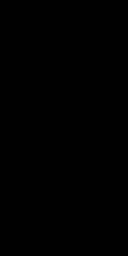

cor_view


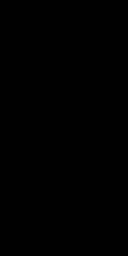

sag_view


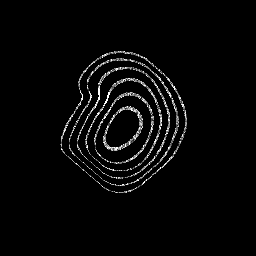

In [5]:
import nibabel as nb
import PIL
import IPython.display

# Capture the first 10 patients 3d scans
imgs = []
for patient in patients[:10]:
    scans = all_patients[patient]['xnat:scans']['xnat:scan']
    for scan in scans:
        imgs.append(nb.load(scan['xnat:file']['@URI']).get_fdata().squeeze())

# Captures the slices of each
tra_view = [PIL.Image.fromarray(imgs[0][i, :, :]) for i in range(imgs[0].shape[0])]
cor_view = [PIL.Image.fromarray(imgs[0][:, i, :]) for i in range(imgs[0].shape[1])]
sag_view = [PIL.Image.fromarray(imgs[0][:, :, i]) for i in range(imgs[0].shape[2])]

# Save the sequence of images as a GIF
views = {'tra_view': tra_view, 'cor_view': cor_view, 'sag_view': sag_view}
for name, view in views.items():
    output_path = f"graphics/{name}.gif"
    view[0].save(output_path, save_all=True, append_images=view[1:], duration=100, loop=0)
    print(name)
    display(IPython.display.Image(filename=output_path))

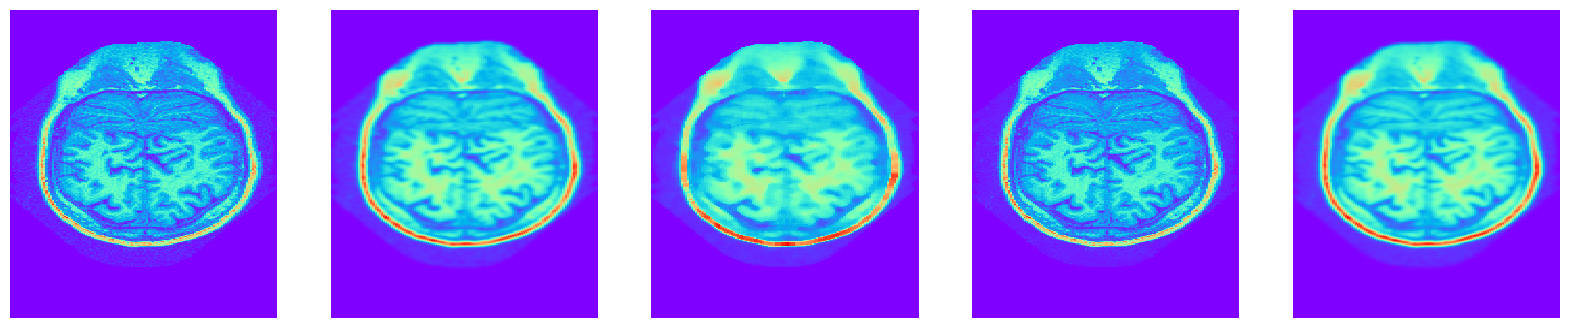

In [6]:
import seaborn as sns
import cv2
import scipy.ndimage
img = np.array(tra_view[66])
plt.figure(figsize= (20,4))
ax = plt.subplot(1,5,1)
sns.heatmap(img,cmap = "rainbow",cbar = False)
ax.set_xticks([])
ax.set_yticks([])
ax = plt.subplot(1,5,2)
sns.heatmap(cv2.GaussianBlur(img,(5,5),0),cmap = "rainbow",cbar = False)
ax.set_xticks([])
ax.set_yticks([])
ax = plt.subplot(1,5,3)
sns.heatmap(cv2.medianBlur(img,5),cmap = "rainbow",cbar = False)
ax.set_xticks([])
ax.set_yticks([])
ax = plt.subplot(1,5,4)
sns.heatmap(cv2.bilateralFilter(img,9,75,75),cmap = "rainbow",cbar = False)
ax.set_xticks([])
ax.set_yticks([])
ax = plt.subplot(1,5,5)
sns.heatmap(scipy.ndimage.gaussian_filter(imgs[0],sigma=1)[66, :, :],cmap = "rainbow",cbar = False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [7]:
def resize_image(image, new_height, new_width):
    # Mask of non-zeros
    mask = image!=0 # Use a >tolerance for a tolerance defining black border

    # Mask of non-zero rows and columns
    mask_row = mask.any(1)
    mask_col = mask.any(0)

    # First, last indices among the non-zero rows
    sr0,sr1 = mask_row.argmax(), len(mask_row) - mask_row[::-1].argmax()

    # First, last indices among the non-zero columns
    sc0,sc1 = mask_col.argmax(), len(mask_col) - mask_col[::-1].argmax()

    # Finally slice along the rows & cols with the start and stop indices to get 
    # cropped image. Slicing helps for an efficient operation.
    image = image[sr0:sr1, sc0:sc1]
    # image_area = {"height": sr1-sr0, "width": sc1-sc0}

    # Original dimensions
    original_height, original_width = image.shape[:2]

    # Create an empty array for the resized image
    resized_image = np.zeros((new_height, new_width), dtype=np.float64)

    # Calculate the ratio of old dimensions to new dimensions
    row_ratio = original_height / new_height
    col_ratio = original_width / new_width

    # Map each pixel of the resized image to the nearest pixel of the original image
    for i in range(new_height):
        for j in range(new_width):
            # Find the nearest pixel in the original image
            original_i = int(i * row_ratio)
            original_j = int(j * col_ratio)

            # Assign the pixel value
            resized_image[i, j] = image[original_i, original_j]

    return resized_image

In [8]:
tra, cor, sag, Z, Y = [], [], [], [], []
for _, p in all_patients.items():
    for s in p['xnat:scans']['xnat:scan']:
        scan = s['xnat:file']['@URI']
        try:
            img = nb.load(scan)
            tra.append(img.get_fdata().squeeze())
            cor.append(img.get_fdata().squeeze())
            sag.append(img.get_fdata().squeeze())
        except:
            print(f"Error: {scan}")
        # print(s)

In [9]:
np.not_equal(Y, None).sum()

0

In [10]:
tra, cor, sag, Z, Y = [], [], [], [], []
for patient in patients:
    p = all_patients[patient]
    scans = p['xnat:scans']['xnat:scan']
    scan = scans[np.random.randint(0,len(scans))] # Randomly select a scan
    img = np.array(nb.load(scan['xnat:file']['@URI']).get_fdata().squeeze(), dtype=np.float32)
    test = img[round(img.shape[0]/2),:,:]
    tra.append(resize_image(cv2.bilateralFilter(test,9,75,75), 96, 96))
    cor.append(resize_image(cv2.bilateralFilter(img[:,round(img.shape[1]/2),:],9,75,75), 96, 96))
    sag.append(resize_image(cv2.bilateralFilter(img[:,:,round(img.shape[2]/2)],9,75,75), 96, 96))
    Z.append([p['metadata'][m] for m in ['AGE','MALE','nWBV']])
    Y.append(p['metadata']['MMSE'])
Y = np.array(Y)

In [11]:
from cskpd import *
from interface import *
from statsmodels.genmod.families.links import *
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from scipy.signal import convolve2d
from sklearn.model_selection import KFold
class SKPDRegressor(RegressorMixin, BaseEstimator):
    def __init__(self,p_list,d_list,lmbda_set,lmbda2_set,R_list,n_cores = -1,max_iter = 20,print_iter = 5,cuda=False,g=Identity,K=None,L=None,impute=0):
        self.p_list = p_list
        self.d_list = d_list
        self.lmbda_set = lmbda_set
        self.lmbda2_set = lmbda2_set
        self.R_list = R_list
        self.n_cores = n_cores
        self.max_iter = max_iter
        self.print_iter = print_iter
        self.cuda = cuda
        self.g = g
        self.K = K
        self.L = L
        self.impute = impute

    def fit(self, X, y):
        if self.K is not None:
            X = [convolve2d(x, self.K, mode='same') for x in X]
            self.xk = X
        y[np.equal(y, None)] = self.impute
        y = np.array(y, dtype=np.float64)
        input_params = {
            "p_list":self.p_list,
            "d_list":self.d_list,
            "lmbda_set":self.lmbda_set,
            "lmbda2_set":self.lmbda2_set,
            ## Z_train is None, when not consider covariate
            "Z_train":None,
            "X_train":X,
            "Y_train":self.g(y),
            ## n_cores is the number of cores for parallel computing, when n_cores = None, we only use a single core in our paper
            ## you can use n_cores > 1 for accelerating your computing
            "R_list":self.R_list, "n_cores":self.n_cores,"max_iter":self.max_iter,"print_iter":self.print_iter}
            # p_list,d_list,lmbda_set,lmbda2_set,Z_train,X_train,Y_train,R_list,n_cores = -1,max_iter = 20,print_iter = 5, cuda=False
        a_hat,b_hat,self.gamma_hat,self.lmbda_1,self.lmbda_2,self.R,self.p,self.d = skpdRegressor(**input_params) 
        A,B,kron_ab = func_kron_ab(a_hat,b_hat,self.R,self.p,self.d)
        self.C_hat = kron_ab[-1]
        return self
    
    def predict(self, X):
        if self.K is not None:
            X = [convolve2d(x, self.K, mode='same') for x in X]
        y_hat = [self.g.inverse(np.vdot(x,self.C_hat)) for x in X]
        return y_hat

def custom_auc(cutoff_point=0):
    def auc(y_true, y_pred):
        idx = ~np.equal(y_true, None)
        print(list(zip(y_true[idx], np.array(y_pred)[idx])))
        y_pred_relu = y_pred * (np.array(y_pred)>cutoff_point)
        y_pred_softmax = np.exp(np.array(y_pred_relu - np.max(y_pred_relu)).astype(np.float64)) / np.sum(np.exp(np.array(y_pred_relu - np.max(y_pred_relu)).astype(np.float64)))
        return roc_auc_score(list(np.array(y_true[idx])>cutoff_point), y_pred_softmax[idx])
    return auc

def custom_acc(cutoff_point=0):
    def accuracy(y_true, y_pred):
        idx = ~np.equal(y_true, None)
        return np.average((np.array(y_true[idx])>cutoff_point)==(np.array(y_pred[idx])>cutoff_point))
    return accuracy


def calc_score(model, X, y, k_folds=5, y_imputer=None):
    scorers = {
        'auc': make_scorer(custom_auc(24), greater_is_better=True),
    }
    if y_imputer is not None:
        y = y_imputer.transform(y)
    results = cross_validate(model, X, y, cv=KFold(k_folds, shuffle=True, random_state=0), scoring=scorers, return_estimator=True)
    print("5-Fold CV AUC Scores: ", results['test_auc'])
    print("Average 5-Fold CV AUC: ", np.nanmean(np.array(results['test_auc'])))
    print("5-Fold CV AUC Scores: ", results['test_auc'])
    print("Average 5-Fold CV AUC: ", np.nanmean(np.array(results['test_auc'])))
    return results

In [13]:
g = NegativeBinomial()
## lambda 1 candidate, corresponds to the lambda in the paper
lmbda_set = [0.1,0.4,0.6,0.9]
## We set lambda2 equals 0 all the time in the paper.
lmbda2_set = [0,0.01,0.1]
## tuning R in this candidate set
## We refer to implement R = 1 first when smaple size is limited
R_list = [1,2,3]
n_cores = 4
## the dim of underlying C is (D1,D2,D3), which satisfies D1 = p1 * d1, D2 = p2 * d2 and D3 = p3 * d3 
p_list = [[12,12],[24,24]]
d_list = [[8,8],[4,4]]

In [14]:
# Create a custom colormap to hide 0 values
import matplotlib.colors as mcolors
cmap = plt.cm.gray
cmap = cmap(np.arange(cmap.N))
cmap[0, -1] = 0 # first color transparency
cmap[1:, -1] = 0.5 # alpha value
custom_cmap = mcolors.ListedColormap(cmap)
def plot_model(name, model_results, X, y, cutoff_point=0):
    C_hat = model_results['estimator'][np.argmax(model_results['test_auc'])].C_hat

    fig = plt.figure(figsize=(8,4))
    # Demented Brain
    plt.subplot(1, 2, 1)
    sns.heatmap(X[np.argmin(y[~np.equal(y, None)])], cmap='viridis', cbar=False)
    sns.heatmap(np.abs(C_hat), cmap=custom_cmap, cbar=False)  # Assuming grayscale or using first channel for RGB
    plt.title('Demented Brain')

    # Non-Demented Brain
    plt.subplot(1, 2, 2)
    sns.heatmap(X[np.argmax(y[~np.equal(y, None)])], cmap='viridis', cbar=False)
    sns.heatmap(np.abs(C_hat), cmap=custom_cmap, cbar=False)  # Assuming grayscale or using first channel for RGB
    plt.title('Non-Demented Brain')

    fig.suptitle(name)

    plt.show()

COR Horizontal Edges
MBIC values:  [-2577.5256034474623, -1191.6261469999624, -2552.1873120763107, -883.762171377387, -2108.746992096373, -1110.0004227169738, -2577.525608123145, -1191.626147239652, -2552.187314365978, -883.7621716205995, -2108.743260653395, -1110.0004240349226, -2577.5256502039256, -1191.6261493976178, -2552.1873349824373, -883.7621738094304, -2108.7092828671034, -1110.0004358964452, -2705.9047749666406, -1835.2383614678702, -2615.977719538406, -1693.4797442550023, -2575.017127940988, inf, -2705.904775365225, -1835.2383616903398, -2615.981920294018, -1693.4797445361348, -2575.017135410194, -1713.6563134695064, -2705.904778952487, -1835.2383636929694, -2616.0195844933364, -1693.4797470662595, -2575.01720262789, -1713.6563965392213, -2710.6986956819123, -2057.6639190087544, -2668.751596737733, -1889.7777109332849, -2672.30620597371, -2125.711426611083, -2710.6986962721803, -2057.663919235156, -2668.75170686168, -1889.7777112323663, -2672.3062001251114, -2125.71143416820

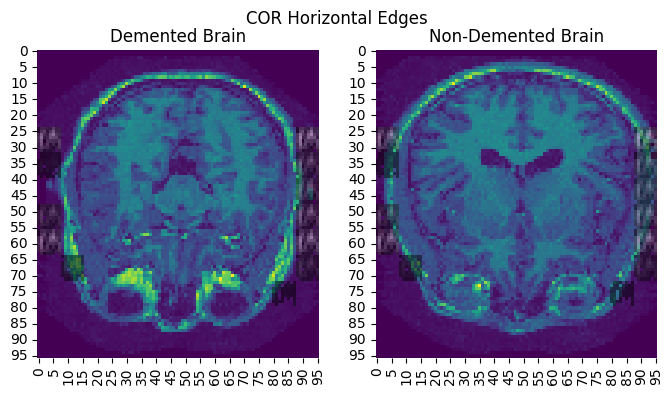

In [15]:
horizontal_kernel = np.array([[-1, 0, 1],
                              [-2, 0, 2],
                              [-1, 0, 1]])
g = NegativeBinomial()
name = "COR Horizontal Edges"
print(name)
model2 = SKPDRegressor(p_list=p_list,d_list=d_list,lmbda_set=lmbda_set,lmbda2_set=lmbda2_set,R_list=R_list,n_cores=n_cores,max_iter = 50,g=g,K=horizontal_kernel, impute=29.46)
model2_results = calc_score(model2, cor, Y, k_folds=3)
plot_model(name, model2_results, cor, Y)

SAG Vertical Edges
MBIC values:  [-1838.8655961175086, -588.0083460992341, -1604.2046712859353, -276.16206470164616, -1275.0283282741682, -181.46302879575933, -1838.8655961011596, -588.0083460933952, -1604.2046712275917, -276.16206470469206, -1275.0283280206106, -181.46302880747226, -1838.8655959540288, -588.0083460408309, -1604.2046707024904, -276.16206473209604, -1275.028325738546, -181.46302891289952, -2064.481726426219, -913.2161182209263, -2035.7426804323834, -646.9485345427511, -1804.3345193525638, -394.21788977381493, -2064.4817264257617, -913.2161182204761, -2035.7426804126105, -646.9485345479334, -1804.3345198220895, -394.21788976769085, -2064.481726421643, -913.2161182164166, -2035.7426802346447, -646.9485345945723, -1804.3345240478598, -394.2178897125741, -2109.0654418178865, -1142.5726964098722, -2115.645957011904, -765.1897973608684, -1941.5587460312527, -696.1781047534796, -2109.0654418204304, -1142.5726964102855, -2115.6459570333354, -765.1897973681457, -1941.55874661698

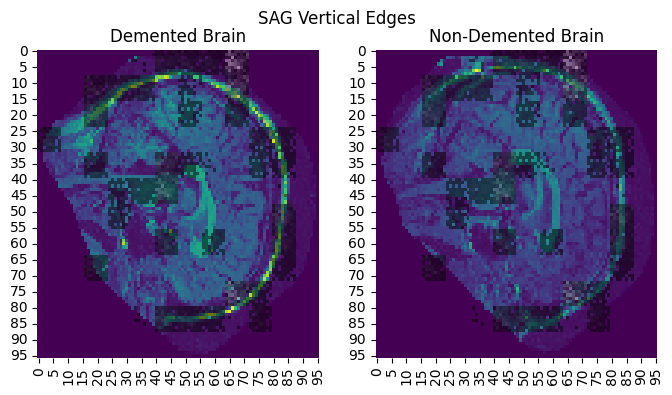

In [16]:
kernel = np.array([[-1, -1, -1],
                              [-1, 8, -1],
                              [-1, -1, -1]])
g = NegativeBinomial()
name = "SAG Vertical Edges"
print(name)
model2 = SKPDRegressor(p_list=p_list,d_list=d_list,lmbda_set=lmbda_set,lmbda2_set=lmbda2_set,R_list=R_list,n_cores=n_cores,max_iter = 50,g=g,K=kernel, impute=29.46)
model2_results = calc_score(model2, sag, Y, k_folds=3)
plot_model(name, model2_results, sag, Y)

In [17]:
del views, view, tra_view, cor_view, sag_view